In [ ]:
# Download dependencies
!pip install imgaug
!apt-get update && apt-get install -y python3-opencv
!pip install keras-flops

# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.layer_utils import count_params
from keras_flops import get_flops
import sys
import os
import random
from imgaug import augmenters as iaa

# function: print train and val loss and accuracy 
def print_graphs(history_record):
    print(history_record.history.keys())
    # summarize history for accuracy
    plt.plot(history_record.history['accuracy'])
    plt.plot(history_record.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
  
    # summarize history for loss
    plt.plot(history_record.history['loss'])
    plt.plot(history_record.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# function: gradcam visualization on GHOSTFACE's attention
def plot_gradcam(index_img, model):
    
    emotion_dict = {0:"Surprise", 1:"Fear", 2: "Disgusted", 3: "Happiness", 4: "Sadness", 5: "Anger", 6: "Neutral"}
    
    # Plot test images
    image = X_test[index_img]
    
    # output of last convolution layer
    last_conv_layer_name = 'block162_conv_1'
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # create model that takes the output of the model above, uses the remaining layers to get final predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    #     TO DO: ADD LAYERS GLOBAL AVERAGE POOLING AND DENSE LAYER
    for layer_name in ["global_average_pooling", "fc1", "classifier"]:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        last_conv_layer_output = last_conv_layer_model(inputs)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    gradcam = np.mean(last_conv_layer_output, axis=-1)
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (224, 224))

    plt.figure(figsize=(7, 7))
    
    ax = plt.subplot(1, 2, 1)
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    plt.title('Original Image: {}'.format(emotion_dict[np.argmax(Y_test[index_img])]))
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(image.astype('uint8'))
    plt.imshow(gradcam, alpha=0.5)
    plt.axis('off')
    plt.title('Predicted: {}'.format(emotion_dict[np.argmax(model.predict(X_test[index_img][tf.newaxis, ...]))]))
    plt.tight_layout()
    plt.show()

In [ ]:
# Import RAF-DB data set
X_train = np.load('rafdb/X_train_rafdb.npy')
Y_train = np.load('rafdb/Y_train_rafdb.npy')
X_dev = np.load('rafdb/X_val_rafdb.npy')
Y_dev = np.load('rafdb/Y_val_rafdb.npy')
X_test = np.load('rafdb/X_test_rafdb.npy')
Y_test = np.load('rafdb/Y_test_rafdb.npy')

print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape, Y_test.shape)

(11043, 224, 224, 3) (11043, 7)
(1228, 224, 224, 3) (1228, 7)
(3068, 224, 224, 3) (3068, 7)


In [ ]:
# Control factor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rotation_range=25, horizontal_flip=True, 
                                   width_shift_range=0.25, height_shift_range=0.25)
datagen_train.fit(X_train)

In [7]:
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(X_train)

In [8]:
# Triplet Attention Module
def TripletAttention(x, block_code):

    permute_hw = tf.keras.layers.Permute((1, 2, 3))(x)
    concat_hw = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_hw, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_hw, axis=-1), axis=-1)])
    conv_hw = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_hw)
    batchnorm_hw = tf.keras.layers.BatchNormalization()(conv_hw)
    sig_act_hw = tf.keras.layers.Activation('sigmoid')(batchnorm_hw)
    skipconn_hw = tf.keras.layers.Multiply()([sig_act_hw, permute_hw])

    permute_w = tf.keras.layers.Permute((1, 3, 2))(x)
    concat_w = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_w, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_w, axis=-1), axis=-1)])
    conv_w = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_w)
    batchnorm_w = tf.keras.layers.BatchNormalization()(conv_w)
    sig_act_w = tf.keras.layers.Activation('sigmoid')(batchnorm_w)
    skipconn_w = tf.keras.layers.Multiply()([sig_act_w, permute_w])
    repermute_w = tf.keras.layers.Permute((1, 3, 2))(skipconn_w)

    permute_h = tf.keras.layers.Permute((3, 1, 2), name= 'block' + str(block_code) + '_permute1_h')(x)
    concat_h = tf.keras.layers.Concatenate(axis=-1, name= 'block' + str(block_code) + '_concat_h')([tf.expand_dims(tf.math.reduce_max(permute_h, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_h, axis=-1), axis=-1)])
    conv_h = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last', name= 'block' + str(block_code) + '_conv_h')(concat_h)
    batchnorm_h = tf.keras.layers.BatchNormalization(name= 'block' + str(block_code) + '_batchnorm_h')(conv_h)
    sig_act_h = tf.keras.layers.Activation('sigmoid', name= 'block' + str(block_code) + '_sigmoid_h')(batchnorm_h)
    skipconn_h = tf.keras.layers.Multiply(name= 'block' + str(block_code) + '_mult_h')([sig_act_h, permute_h])
    repermute_h = tf.keras.layers.Permute((3, 2, 1), name= 'block' + str(block_code) + '_permute2_h')(skipconn_h)

    average_lyr = tf.keras.layers.Average(name='block' + str(block_code) + '_average')([skipconn_hw, repermute_w, repermute_h])
    return average_lyr

# Fused MB-Convolution Module
def fused_conv(x, block_num, filters, strides, attention=False):
    x1 = layers.Conv2D(filters=filters, kernel_size=3, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    if attention == True:
        x1 = TripletAttention(x1, block_num)

    x2 = layers.Conv2D(filters=filters, kernel_size=strides, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_2')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)

    if strides!=2:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
    else:
        x3 = x2
        
    return x3

# Ghost Module
def ghostnet_module(x, block_num, filters, kernel_size, strides=1, activation=True):
    x1 = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu1')(x1)
    
    x2 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_dwconv_1')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    if activation==True:
        x2 = layers.Activation('relu', name='block'+str(block_num)+'_relu2')(x2)
    
    x3 = layers.Add(name='block'+str(block_num)+'_add')([x1, x2])
    return x3

# Attention GhostNet Bottleneck
def ghostnet_bottleneck(x, block_num, filters, strides, kernel_size=3):
          
    x1 = ghostnet_module(x, str(block_num) + '1', filters, kernel_size, strides=1, activation=True)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    x1 = TripletAttention(x1, block_num)
    
    x2 = ghostnet_module(x1, str(block_num) + '2', filters, kernel_size, strides=1, activation=False)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    
    b0, h0, w0, c0 = x2.shape 
    if strides>1:
        if c0!=filters*2:
            x = layers.DepthwiseConv2D(kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv_correction')(x)
            x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_conv_correction')(x)
        
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
        x3 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=2, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv1')(x3)
    else:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])

    return x3

# GHOSTFACE CLASSIFICATION MODEL 
def classification_model(input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', use_bias=False, name='normal_conv_1')(norm)
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [14]:
get_flops(classification_model())/10**6 # MFLOPS

134.655852

In [13]:
count_params(classification_model().weights) # total params

1285619

In [12]:
count_params(classification_model().trainable_weights) # trainable params

1278130

In [ ]:
# MIXUP Augmentation
def shuffle(X_train_mixup, Y_train_mixup):
    zipped = zip(X_train_mixup, Y_train_mixup)
    zip_list = list(zipped)
    random.shuffle(zip_list)
    print(X_train_mixup.shape, Y_train_mixup.shape)
    imgs = [zip_list[i][0] for i in range(X_train_mixup.shape[0])]
    x_shuffled_mixup = np.asarray(imgs)

    lbls = [zip_list[i][1] for i in range(X_train_mixup.shape[0])]
    y_shuffled_mixup = np.asarray(lbls)

    print(x_shuffled_mixup.shape, y_shuffled_mixup.shape)
    
    return x_shuffled_mixup, y_shuffled_mixup

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(x_train_ds_1, y_train_ds_1, alpha=0.20):
    
    s = shuffle(X_train[1000:3760], Y_train[1000:3760])
    batch_size = tf.shape(x_train_ds_1)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = x_train_ds_1 * x_l + s[0] * (1 - x_l)
    labels = y_train_ds_1 * y_l + s[1] * (1 - y_l)
    return images, labels

X_train[6500:9260], Y_train[6500:9260] = mix_up(X_train[6500:9260], Y_train[6500:9260])

(2760, 224, 224, 3) (2760, 7)
(2760, 224, 224, 3) (2760, 7)


2022-07-13 14:14:43.546260: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1661829120 exceeds 10% of free system memory.
2022-07-13 14:14:44.856448: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1661829120 exceeds 10% of free system memory.


In [ ]:
# RandAug Augmentation
def rand_augmentation(X_train_kaug, Y_train_kaug):
    print(X_train_kaug.shape, Y_train_kaug.shape)
    rand_aug = iaa.RandAugment(n=(0, 3), m=(2, 4)) #n=(0, 2), m=(2, 5) with accuracy 77.17 #(n=(0, 3), m=(2, 6)) with accuracy 76.76
    X_train_kaug = rand_aug(images=X_train_kaug.astype('uint8')).astype('float32')
    print(X_train_kaug.dtype, Y_train_kaug.dtype)
    return X_train_kaug, Y_train_kaug

X_train, Y_train = rand_augmentation(X_train, Y_train)

(11043, 224, 224, 3) (11043, 7)
float32 float32


In [ ]:
# Image Normalization
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(X_train)

In [ ]:
# Training with MixUp
batch_size = 16
epochs = 100
learning_rate = 0.1
checkpoint_filepath = '13072022_mixup/chckpt.ckpt'

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

model = classification_model()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
save_weights = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_loss", mode='min', save_best_only=True, save_weights_only=True)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

history = model.fit(datagen_train.flow(X_train, Y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_dev, Y_dev), callbacks=[save_weights, reduce_learning_rate, early_stopping])

Epoch 1/100


2022-07-13 04:17:46.308626: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-07-13 04:17:49.444787: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


691/691 [==============================] - 99s 113ms/step - loss: 1.6569 - accuracy: 0.3858 - val_loss: 1.6464 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 2/100
691/691 [==============================] - 72s 105ms/step - loss: 1.6416 - accuracy: 0.3883 - val_loss: 1.6536 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 3/100
691/691 [==============================] - 73s 106ms/step - loss: 1.6334 - accuracy: 0.3885 - val_loss: 1.6406 - val_accuracy: 0.3721 - lr: 0.1000
Epoch 4/100
691/691 [==============================] - 74s 106ms/step - loss: 1.6308 - accuracy: 0.3891 - val_loss: 1.6402 - val_accuracy: 0.3811 - lr: 0.1000
Epoch 5/100
691/691 [==============================] - 73s 105ms/step - loss: 1.6252 - accuracy: 0.3902 - val_loss: 1.6399 - val_accuracy: 0.3876 - lr: 0.1000
Epoch 6/100
691/691 [==============================] - 72s 105ms/step - loss: 1.6245 - accuracy: 0.3878 - val_loss: 1.7335 - val_accuracy: 0.3200 - lr: 0.1000
Epoch 7/100
691/691 [==============================] - 74s

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('model loss: {}%'.format(loss))
print('model accuracy: {}%'.format(accuracy))

96/96 [==============================] - 2s 20ms/step - loss: 0.6551 - accuracy: 0.7761
model loss: 0.6551356911659241%
model accuracy: 0.7760756015777588%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


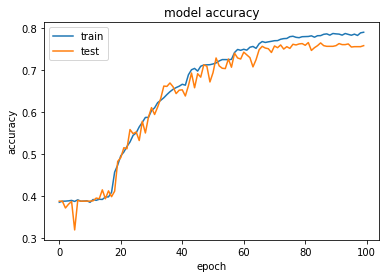

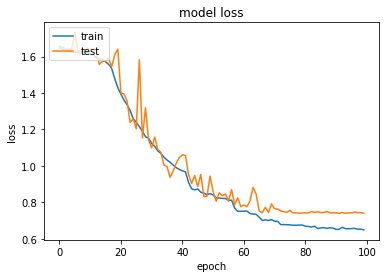

In [ ]:
print_graphs(history)

In [ ]:
# Training with MixUp, RandAug
batch_size = 16
epochs = 100
learning_rate = 0.1
checkpoint_filepath = '13072022_mixup_randaug/chckpt.ckpt'

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)

model = classification_model()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
save_weights = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_loss", mode='min', save_best_only=True, save_weights_only=True)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

history = model.fit(datagen_train.flow(X_train, Y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_dev, Y_dev), callbacks=[save_weights, reduce_learning_rate, early_stopping])

Epoch 1/100


2022-07-13 14:16:46.994672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-07-13 14:16:50.952931: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


691/691 [==============================] - 108s 118ms/step - loss: 1.6678 - accuracy: 0.3839 - val_loss: 1.6757 - val_accuracy: 0.3591 - lr: 0.1000
Epoch 2/100
691/691 [==============================] - 79s 114ms/step - loss: 1.6482 - accuracy: 0.3869 - val_loss: 1.6306 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 3/100
691/691 [==============================] - 77s 112ms/step - loss: 1.6451 - accuracy: 0.3835 - val_loss: 1.6528 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 4/100
691/691 [==============================] - 77s 111ms/step - loss: 1.6364 - accuracy: 0.3861 - val_loss: 1.6148 - val_accuracy: 0.3941 - lr: 0.1000
Epoch 5/100
691/691 [==============================] - 78s 113ms/step - loss: 1.6377 - accuracy: 0.3873 - val_loss: 1.6406 - val_accuracy: 0.3893 - lr: 0.1000
Epoch 6/100
691/691 [==============================] - 78s 112ms/step - loss: 1.6376 - accuracy: 0.3849 - val_loss: 1.6518 - val_accuracy: 0.3884 - lr: 0.1000
Epoch 7/100
691/691 [==============================] - 77

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('model loss: {}%'.format(loss))
print('model accuracy: {}%'.format(accuracy))

96/96 [==============================] - 2s 20ms/step - loss: 0.6797 - accuracy: 0.7696
model loss: 0.6797215938568115%
model accuracy: 0.7695567011833191%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


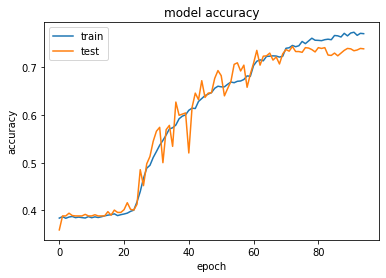

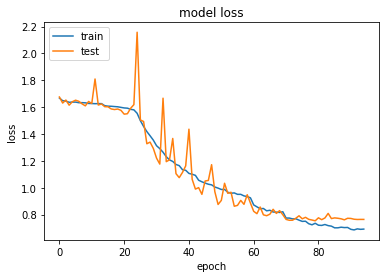

In [ ]:
print_graphs(history)